This notebook demonstrates the code used in measuring the ETF trading volume to quantify high volume days. In short, it retrieves the volume metrics for the ETF and identifies days with volume greater than 90th percentile.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style
from time import sleep

set_style("whitegrid")

In [2]:
def get_ticker_data(ticker,period='max',start_date=None,end_date=None):
   # Wrapper to return ticker data for a specified range (probably not needed)
   # Cleans up dataframe and adds returns
   if start_date is not None:
      data = yf.Ticker(ticker).history(start=start_date, end=end_date)
   else:
      data = yf.Ticker(ticker).history(period='max')

   # drop unnecessary columns
   data = data.drop(["Dividends", "Stock Splits", "Capital Gains"], axis=1)
   # add returns
   data['Returns'] = (data['Close'] - data['Close'].shift(1))/data['Close'].shift(1)
   data['Log_Returns'] = np.log10(data['Close']/data['Close'].shift(1))

   return data

def quantile_slice(ticker_data, column='Volume', quantile=0.8):
    # A method to return the dates above a specified quantile
    new_data = data[np.log10(data[column])>np.log10(data[column]).quantile(quantile)]
    return new_data

In [3]:
# define our time range that we would like to use

start_date = pd.Timestamp('2019-10-01')
end_date = pd.Timestamp('2023-04-01')

In [4]:
# get data for specified range or for all available data ('max')

data = get_ticker_data('XLB',start_date=start_date, end_date=end_date)
#data = get_ticker_data('XLB',period='max')
data

,Open,High,Low,Close,Volume,Returns,Log_Returns
Date,,,,,,,
2019-10-01 00:00:00-04:00,53.133380,53.315688,51.793423,51.802540,7304500,NaN,NaN
2019-10-02 00:00:00-04:00,51.319422,51.392347,50.389656,50.872772,11680400,-0.017948,-0.007866
2019-10-03 00:00:00-04:00,50.745147,51.064186,50.225572,51.055069,8265000,0.003583,0.001553
2019-10-04 00:00:00-04:00,51.091532,51.447030,51.045956,51.328533,6292900,0.005356,0.002320
2019-10-07 00:00:00-04:00,51.191801,51.674913,50.991262,51.146225,8628600,-0.003552,-0.001545
...,...,...,...,...,...,...,...
2023-03-27 00:00:00-04:00,76.054158,76.367743,75.279995,75.828766,5307000,0.007421,0.003211
2023-03-28 00:00:00-04:00,75.818966,76.318736,75.740568,76.191345,5124000,0.004782,0.002072
2023-03-29 00:00:00-04:00,77.171297,77.298688,76.906713,77.249695,4135100,0.013891,0.005991


In [5]:
# looking the correlations, we can see that the strongest correlation is between Volume and Returns (or Log_Returns).
# It is a slight negative correlation, it is the strongest correlate with Returns overall.
data.corr()

,Open,High,Low,Close,Volume,Returns,Log_Returns
Open,1.000000,0.999087,0.998988,0.997911,-0.093047,-0.021338,-0.013558
High,0.999087,1.000000,0.998791,0.999042,-0.082118,-0.004056,0.003253
Low,0.998988,0.998791,1.000000,0.999007,-0.110609,0.002229,0.010169
Close,0.997911,0.999042,0.999007,1.000000,-0.097605,0.021754,0.029271
Volume,-0.093047,-0.082118,-0.110609,-0.097605,1.000000,-0.121069,-0.129489
Returns,-0.021338,-0.004056,0.002229,0.021754,-0.121069,1.000000,0.999648
Log_Returns,-0.013558,0.003253,0.010169,0.029271,-0.129489,0.999648,1.000000


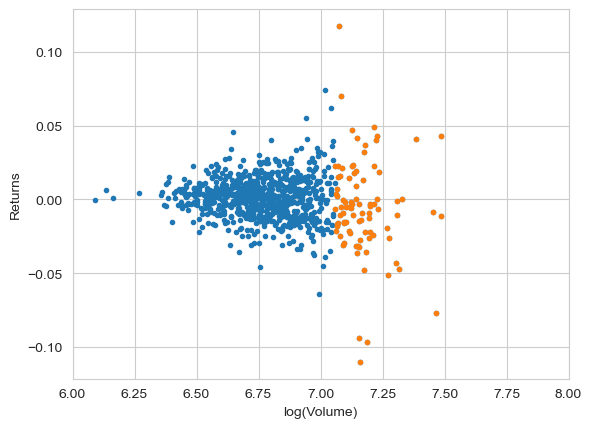

In [6]:
fig, ax = plt.subplots()

sdata = quantile_slice(data,quantile=0.9)

ax.plot(np.log10(data['Volume']),data['Returns'],'.')
ax.plot(np.log10(sdata['Volume']),sdata['Returns'],'.')

ax.set_xlabel('log(Volume)')
ax.set_ylabel('Returns')

#high volume is greater than 1e6
ax.set_xlim([6,8])
plt.show()

In [7]:
# Finding the average returns on the highest volume days
print(f"Average daily returns for all data: {np.average(data['Returns'].fillna(0))*100:.2f}%")
print(f"Average daily returns for sliced data: {np.average(sdata['Returns'].fillna(0))*100:.2f}%")

Average daily returns for all data: 0.06%
Average daily returns for sliced data: -0.55%


From this, we can see that the highest volume days tend to produce negative returns for the ETF. This code was tested with the full timespan available from yfinance, and it was found to reduce the loses to an average of roughly -0.3%. Now, let's examine this for all ETFs in this study.

In [11]:
# 
ticker_list = ['XLB','XLC','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']
all_returns = []
quantile_returns = []

full_data = None
for ticker in ticker_list:
    data = get_ticker_data(ticker,period='max')
    sleep(0.1)

    data['High_Volume'] = data['Volume'] > data['Volume'].quantile(q=0.95)
    data['Ticker'] = ticker
    
    #all_returns.append(np.average(data['Returns'].fillna(0)))
    #quantile_returns.append(np.average(sdata['Returns'].fillna(0)))
    if full_data is None:
        full_data = data
    else:
        full_data = pd.concat([full_data,data])


In [12]:
#Make a copy so we can categorize the High_Volume column. Probably a smarter way to do this
full_data2 = full_data.copy()
full_data2.loc[full_data['High_Volume'].values,'High_Volume'] = 'High'
full_data2.loc[~full_data['High_Volume'].values,'High_Volume'] = 'Normal'
full_data2.reset_index(inplace=True)

/var/folders/5k/58l7gqhs0b13k1yyn_v9tq2m0000gn/T/ipykernel_89410/2059584706.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'High' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  full_data2.loc[full_data['High_Volume'].values,'High_Volume'] = 'High'


(-0.11, 0.11)

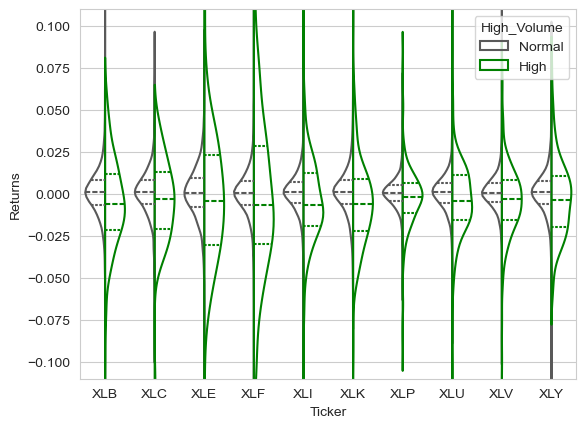

In [13]:
sns.violinplot(data=full_data2, x="Ticker", y="Returns", hue="High_Volume",
               split=True, inner="quart", fill=False, density_norm='width',
               palette={"High": "g", "Normal": ".35"})
plt.ylim([-0.11,0.11])